**9/13/24**

The purpose of this notebook is to graph data from growth curves of vaginal bacteria on the mucin glycans Neu5Ac, GlcNAc, Galactose, GalNAc, and Fucose.

In [1]:
from elliot_utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
filepath = Path.cwd().joinpath('analysis_files/glycan_growth/')
figurepath = Path.cwd().joinpath('figures/glycan_growth/')                        

In [3]:
# Returns: The dataDF appended with a new column representing the OD600 for the sample at the given time minus its starting OD600
# dataDF: Dataframe output by the curveData2df function
def calculateDeltaOD(dataDF):
    startingOD = None
    deltaODs = []
    for index, row in dataDF.iterrows():
        if row['Hours'] == 0:
            startingOD = row['OD600']
            deltaODs.append(0)
        else:
            deltaODs.append(row['OD600'] - startingOD)
    dataDF['Delta OD600'] = deltaODs

# Returns: A subset DataFrame of "df" with only data for the specified strains and treatments
# df: A DataFrame generated by the curveData2df function. It will have the headers 'Treatment', 'OD600', 'Hours'
# strains: A list containing strain names
# treatments: A list containing treatment names
# If time limit is set, will only return up to the given time point in hours (inclusive)
# If treatments is set to a list, will only return values for those treatments
def sliceDFBy(df, strains, treatments, timeLimit=1000000000000):
    dataDict = {}
    for key in df.keys():
        dataDict[key] = []
    for index, row in df.iterrows():
        if row['Strain'] in strains and row['Treatment'] in treatments and row['Hours'] <= timeLimit:
            for key in dataDict.keys():
                dataDict[key].append(row[key])
    return pd.DataFrame(dataDict)

# Object to hold endpoint data values and return them as a normalized percentage of growth on glucose
class GrowthDataHolder:
    def __init__(self):
        self.data = {} #key=strain, value=dict in the format {'treatment':list of delta ODs at 72hrs}
    
    # Add a deltaOD for the specified treatment
    def addData(self, strain, treatment, value):
        if not strain in self.data.keys():
            self.data[strain] = {}
        if not treatment in self.data[strain].keys():
            self.data[strain][treatment] = []
        self.data[strain][treatment].append(value)
    
    # Get a list of data for 'forTreatment' minus the average for negativeTreatment, normalized as a percentage of normalizeTreatment
    def getPercentages(self, strain, forTreatment, negativeTreatment, normalizeTreatment):
        avgNegative = mean(self.data[strain][negativeTreatment])
        if avgNegative < 0:
            avgNegative = 0
        avgNormal = mean(self.data[strain][normalizeTreatment])
        toReturn = []
        for dataPoint in self.data[strain][forTreatment]:
            if avgNormal > avgNegative:
                toReturn.append(((dataPoint - avgNegative) / (avgNormal - avgNegative)) * 100)
            else:
                toReturn.append(((dataPoint - avgNegative) / avgNegative) * 100)
        return toReturn

# Returns a graphable DF that calculates the percent growth of the specified strains on all treatments relative to Glucose, corrected against No Carbs
def getPercentGrowthDF(dataframe, strains, treatments):
    holder = GrowthDataHolder()
    for index, row in dataframe.iterrows():
        if row['Hours'] == 72:
            holder.addData(row['Strain'], row['Treatment'], row['Delta OD600'])
    dataDict = {'Strain':[], 'Treatment':[], 'Percent':[]}
    for strain in strains:
        for treatment in treatments:
            percentages = holder.getPercentages(strain, treatment, 'No Carbs', 'Glucose')
            for percent in percentages:
                dataDict['Strain'].append(strain)
                dataDict['Treatment'].append(treatment)
                dataDict['Percent'].append(percent)
    return pd.DataFrame(dataDict)

# Writes a csv file to "outpath" with the delta OD600 values for each strain in the dataframe at 72hrs
def writeEndpointDelta(dataframe, outpath):
    towrite = {'Strain':[], 'Treatment':[], 'Delta':[]}
    for index, row in dataframe.iterrows():
        if row['Hours'] == 72:
            towrite['Strain'].append(row['Strain'])
            towrite['Treatment'].append(row['Treatment'])
            towrite['Delta'].append(row['Delta OD600'])
    pd.DataFrame(towrite).to_csv(outpath, index=False)

standardTreatmentLocs = [
    ['Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose'],
    ['No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs'],
    ['Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac'],
    ['GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc'],
    ['Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose'],
    ['GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc'],
    ['Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose'],
    ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose', '', '', '', '', '']
]

In [4]:
data91324 = pd.read_csv(filepath.joinpath('9-13-24_gardnerella_vaginalis_piotii.csv'))

In [5]:
strainLocs = [
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df91324 = curveData2df(data91324, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df91324)
getPercentGrowthDF(df91324, ['G. vaginalis ATCC14018', 'G. vaginalis UPII 315-A', 'G. piotii CCUG72427', 'G. piotii JCP8066'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('9-13-24_percentgrowth.csv'))

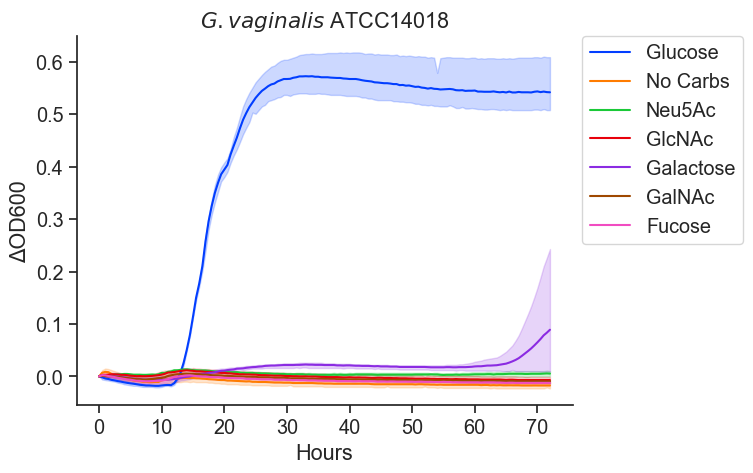

In [6]:
dataToPlot = sliceDFBy(df91324, ['G. vaginalis ATCC14018'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. vaginalis}$ ATCC14018', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-13-24_Gvaginalis_ATCC14018.png'))

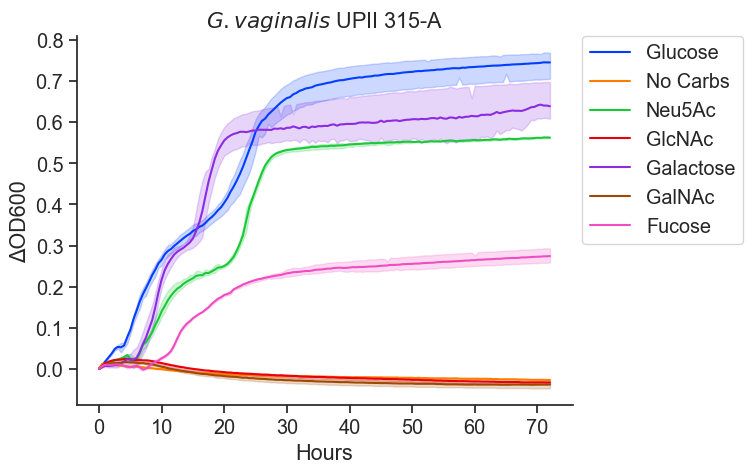

In [7]:
dataToPlot = sliceDFBy(df91324, ['G. vaginalis UPII 315-A'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. vaginalis}$ UPII 315-A', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-13-24_Gvaginalis_UPII315A.png'))

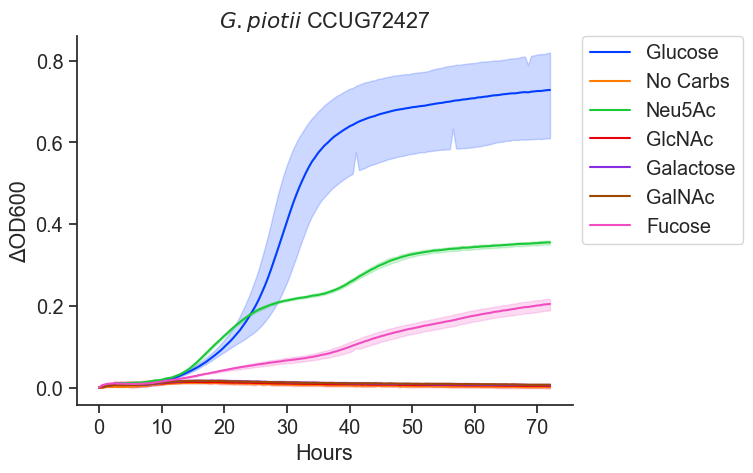

In [8]:
dataToPlot = sliceDFBy(df91324, ['G. piotii CCUG72427'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. piotii}$ CCUG72427', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-13-24_Gpiotii_CCUG72427.png'))

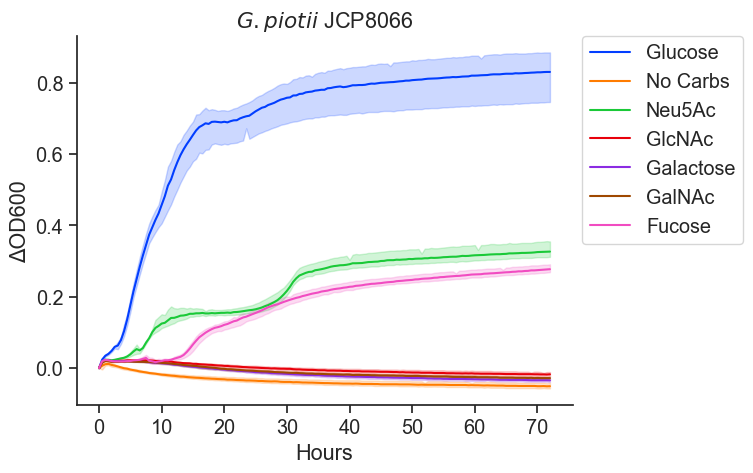

In [9]:
dataToPlot = sliceDFBy(df91324, ['G. piotii JCP8066'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. piotii}$ JCP8066', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-13-24_Gpiotii_JCP8066.png'))

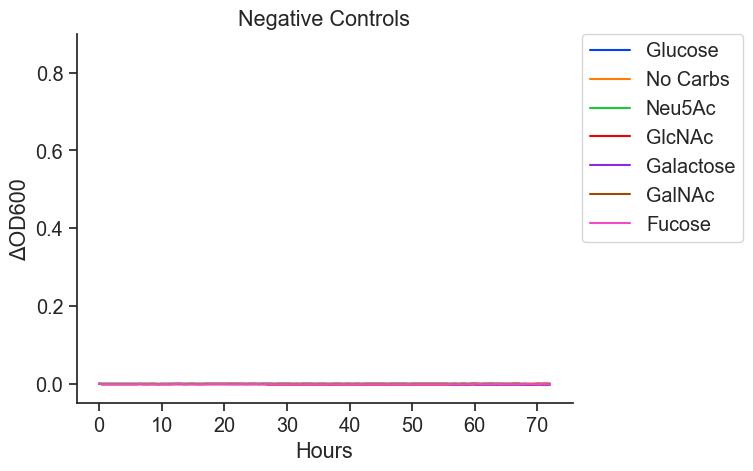

In [10]:
dataToPlot = sliceDFBy(df91324, ['Negative'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='Negative Controls', ylabel='ΔOD600', ylim=(-0.05, 0.9))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()

In [11]:
data91724 = pd.read_csv(filepath.joinpath('9-17-24_gardnerella_vaginalis_leopoldii_swidsinskii.csv'))

In [12]:
strainLocs = [
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df91724 = curveData2df(data91724, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df91724)
getPercentGrowthDF(df91724, ['G. vaginalis ATCC14019', 'G. vaginalis ATCC49145', 'G. leopoldii CCUG72425', 'G. swidsinskii CCUG72429'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('9-17-24_percentgrowth.csv'))

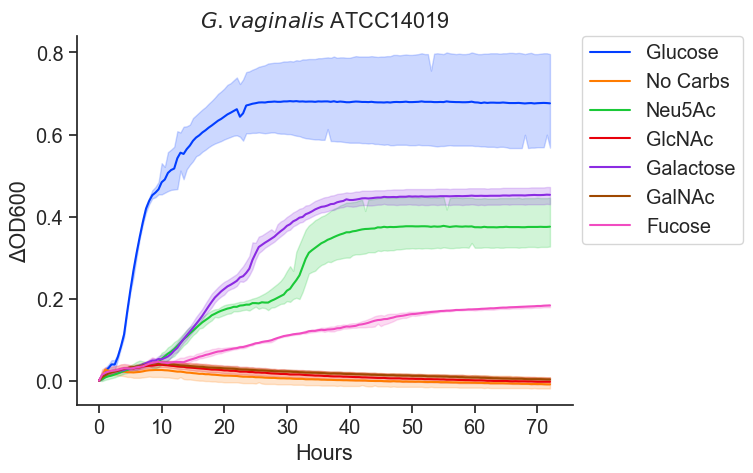

In [13]:
dataToPlot = sliceDFBy(df91724, ['G. vaginalis ATCC14019'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. vaginalis}$ ATCC14019', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-17-24_Gvaginalis_ATCC14019.png'))

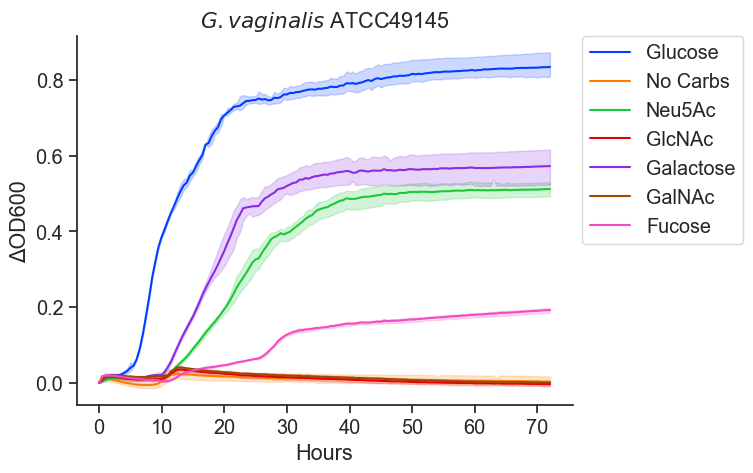

In [14]:
dataToPlot = sliceDFBy(df91724, ['G. vaginalis ATCC49145'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. vaginalis}$ ATCC49145', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-17-24_Gvaginalis_ATCC49145.png'))

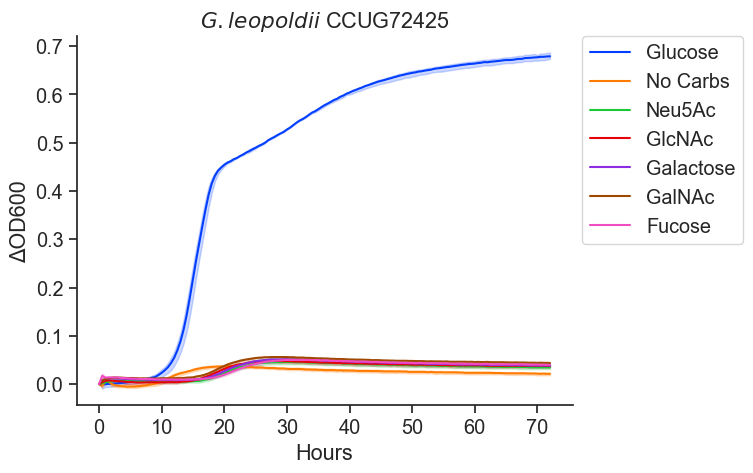

In [15]:
dataToPlot = sliceDFBy(df91724, ['G. leopoldii CCUG72425'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. leopoldii}$ CCUG72425', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-17-24_Gleopoldii_CCUG72425.png'))

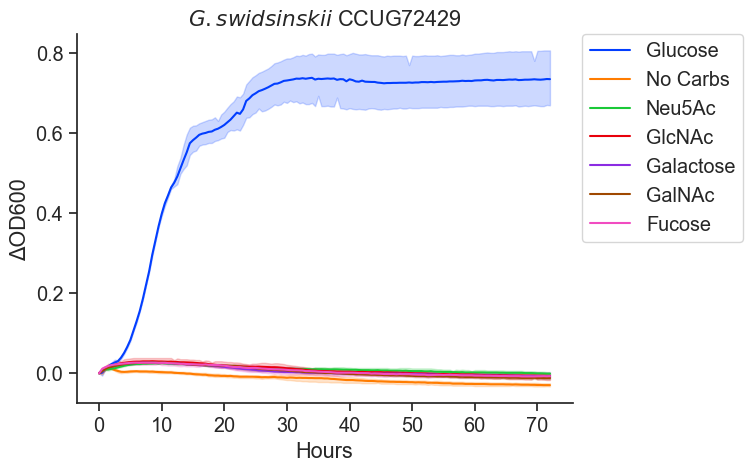

In [16]:
dataToPlot = sliceDFBy(df91724, ['G. swidsinskii CCUG72429'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{G. swidsinskii}$ CCUG72429', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-17-24_Gswidsinskii_CCUG72429.png'))

In [17]:
data92324 = pd.read_csv(filepath.joinpath('9-23-24_Lcrispatus_failed_neu5ac.csv'))

In [18]:
strainLocs = [
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df92324 = curveData2df(data92324, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df92324)
getPercentGrowthDF(df92324, ['L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('9-23-24_percentgrowth.csv'))

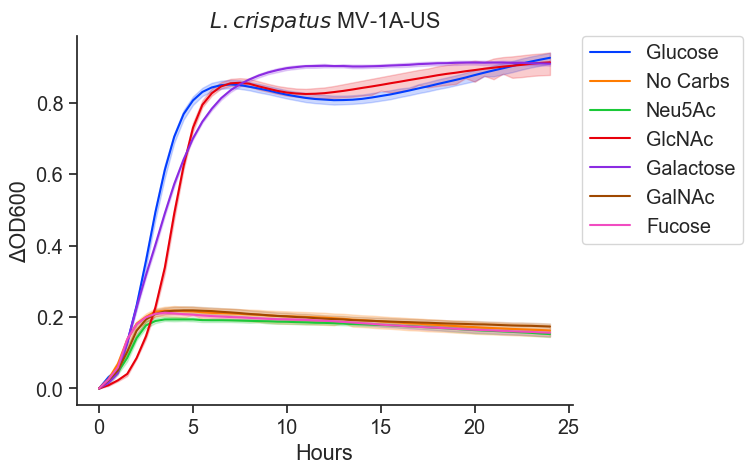

In [19]:
dataToPlot = sliceDFBy(df92324, ['L. crispatus MV-1A-US'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'], timeLimit=24)
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ MV-1A-US', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_MV1AUS.png'))

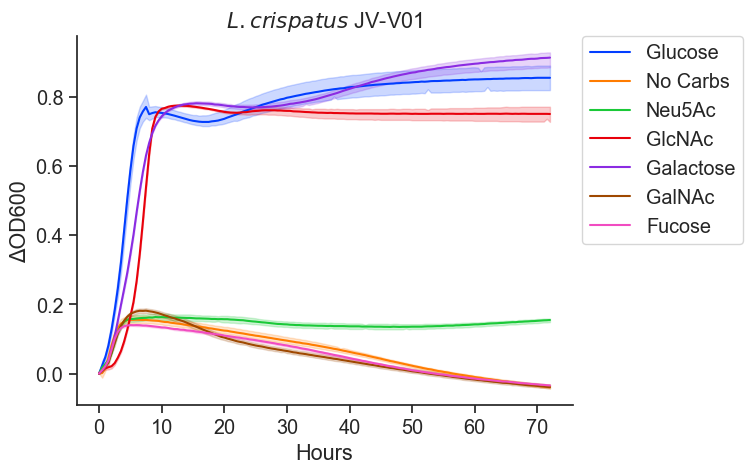

In [20]:
dataToPlot = sliceDFBy(df92324, ['L. crispatus JV-V01'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ JV-V01', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_JVV01.png'))

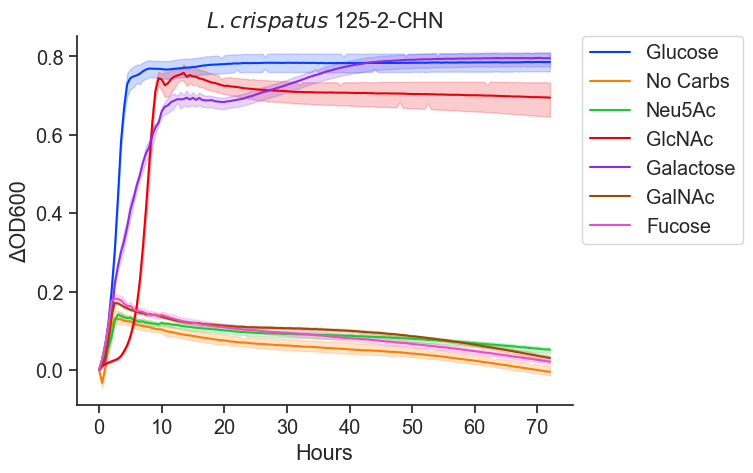

In [21]:
dataToPlot = sliceDFBy(df92324, ['L. crispatus 125-2-CHN'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ 125-2-CHN', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_1252CHN.png'))

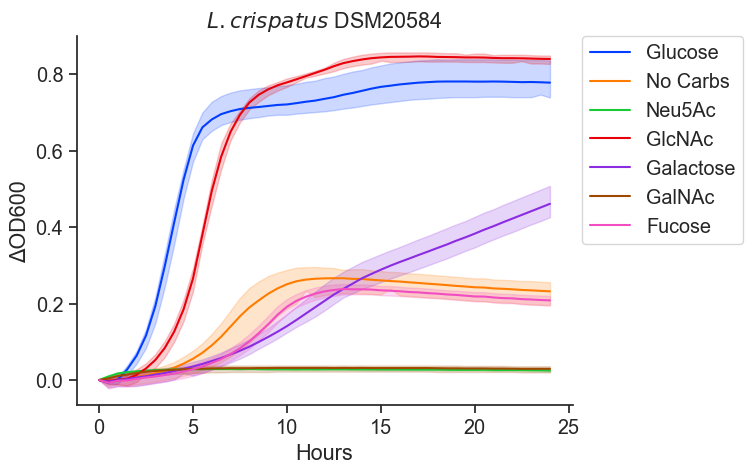

In [22]:
dataToPlot = sliceDFBy(df92324, ['L. crispatus DSM20584'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'], timeLimit=24)
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ DSM20584', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_DSM20584.png'))

In [23]:
# Graph data from the experiment on Prevotella strains, where I used L. crispatus as a positive control
data93024 = pd.read_csv(filepath.joinpath('9-30-24_prevotellas.csv'))
strainLocs = [
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US']
]
treatmentLocs93024 = [
    ['Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose'],
    ['No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs'],
    ['Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac'],
    ['GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc'],
    ['Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose'],
    ['GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc'],
    ['Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose'],
    ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose', 'Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose']
]
df93024 = curveData2df(data93024, strainLocs, treatmentLocs93024)
calculateDeltaOD(df93024)

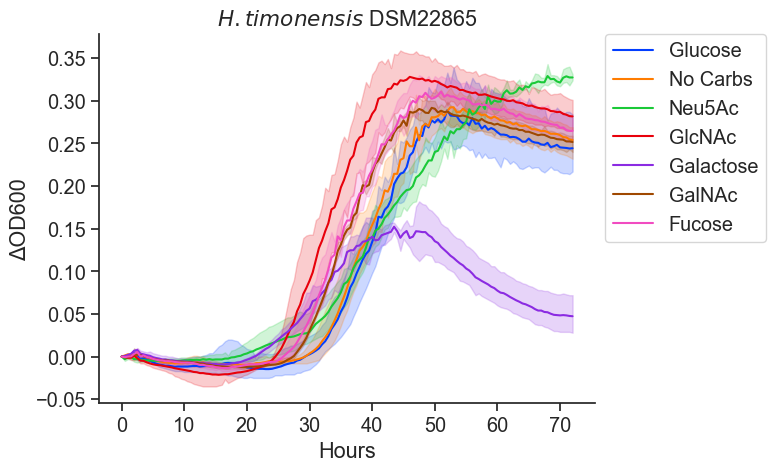

In [24]:
dataToPlot = sliceDFBy(df93024, ['H. timonensis DSM22865'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ DSM22865', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_DSM20584.png'))

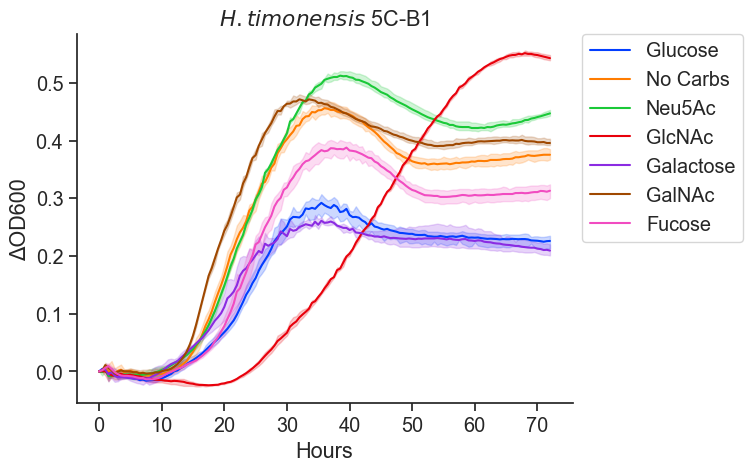

In [25]:
dataToPlot = sliceDFBy(df93024, ['H. timonensis 5C-B1'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ 5C-B1', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_DSM20584.png'))

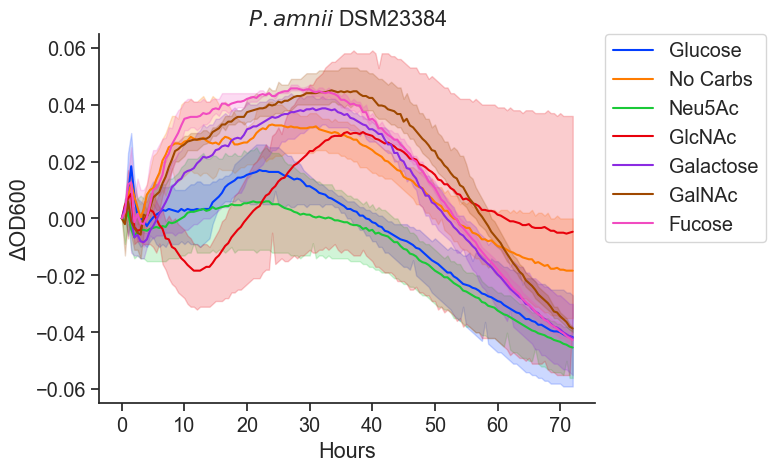

In [26]:
dataToPlot = sliceDFBy(df93024, ['P. amnii DSM23384'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. amnii}$ DSM23384', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_DSM20584.png'))

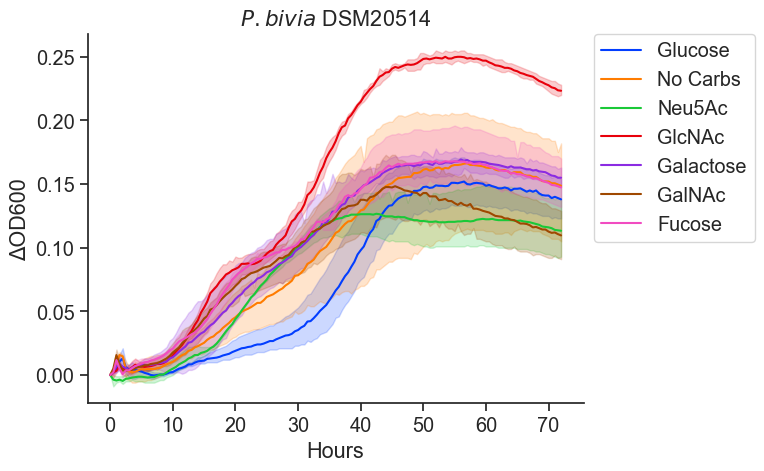

In [27]:
dataToPlot = sliceDFBy(df93024, ['P. bivia DSM20514'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. bivia}$ DSM20514', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('9-23-24_Lcrispatus_DSM20584.png'))

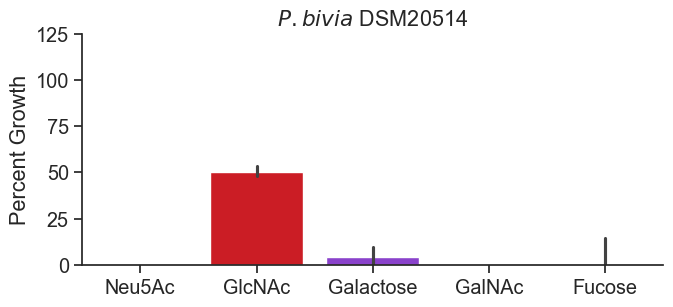

In [28]:
dataToPlot = getPercentGrowthDF(df93024, ['P. bivia DSM20514'], ['Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
fig, ax = plt.subplots(figsize=(7.5, 3))
plot = sns.barplot(ax=ax, data=dataToPlot, x='Treatment', y='Percent', palette=sns.color_palette('bright')[2:7])
plot.set(title='$\it{P. bivia}$ DSM20514', ylabel='Percent Growth', xlabel='', ylim=(0, 125))
sns.despine()

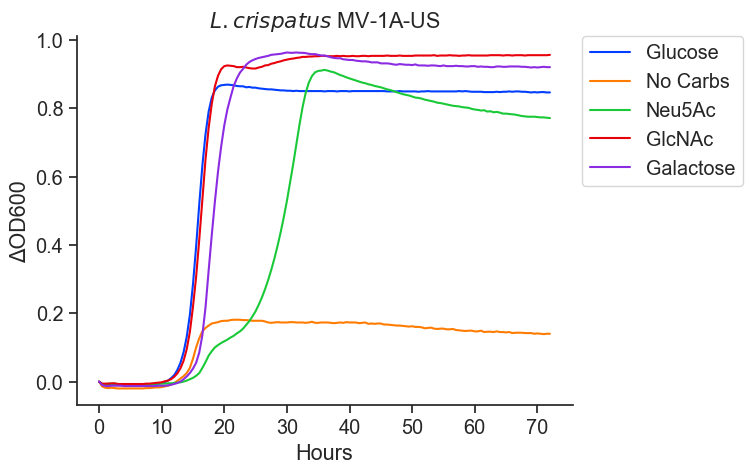

In [29]:
dataToPlot = sliceDFBy(df93024, ['L. crispatus MV-1A-US'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ MV-1A-US', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()

In [30]:
data10424 = pd.read_csv(filepath.joinpath('10-4-24_lactos.csv'))

In [31]:
strainLocs = [
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df10424 = curveData2df(data10424, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df10424)
getPercentGrowthDF(df10424, ['L. iners DSM13335', 'L. iners 143-D', 'L. gasseri DSM20243', 'L. jensenii DSM20557',], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('10-4-24_percentgrowth.csv'))

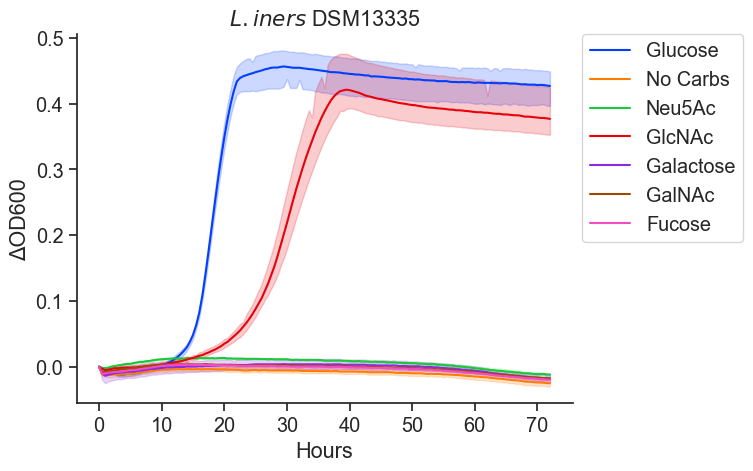

In [32]:
dataToPlot = sliceDFBy(df10424, ['L. iners DSM13335'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. iners}$ DSM13335', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-4-24_Liners_DSM13335.png'))

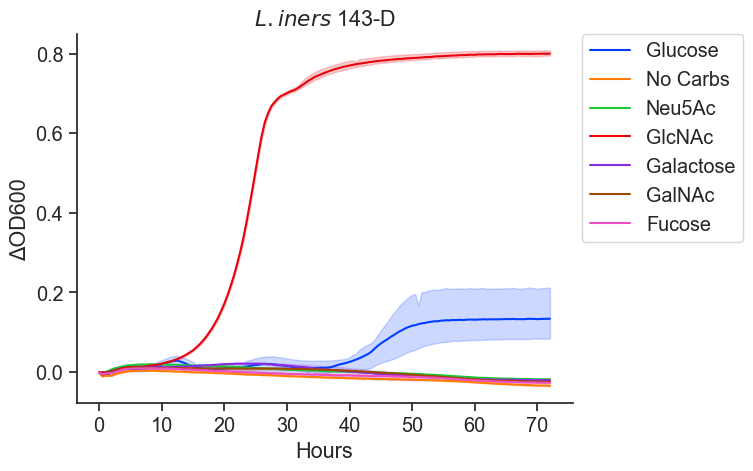

In [33]:
dataToPlot = sliceDFBy(df10424, ['L. iners 143-D'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. iners}$ 143-D', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-4-24_Liners_143D.png'))

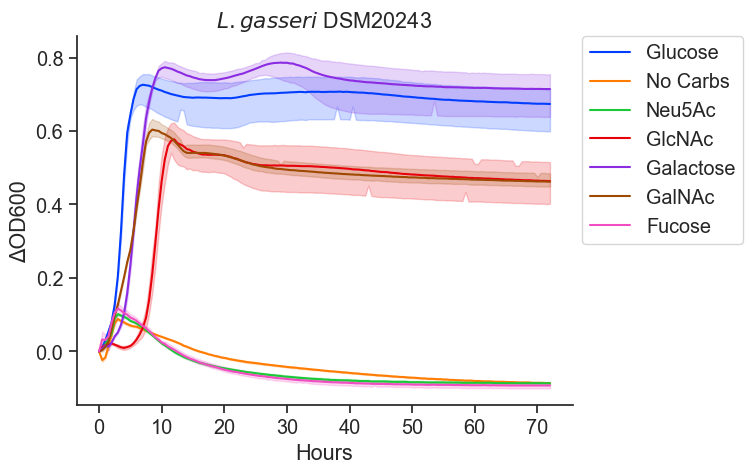

In [34]:
dataToPlot = sliceDFBy(df10424, ['L. gasseri DSM20243'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. gasseri}$ DSM20243', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-4-24_Lgasseri_DSM20243.png'))

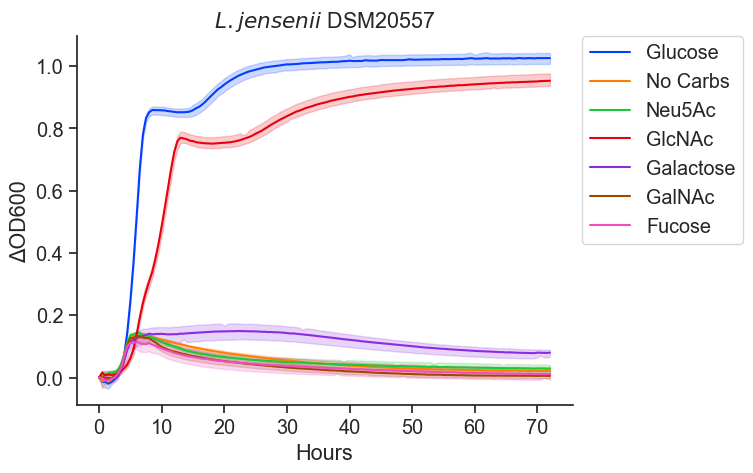

In [35]:
dataToPlot = sliceDFBy(df10424, ['L. jensenii DSM20557'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. jensenii}$ DSM20557', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-4-24_Ljensenii_DSM20557.png'))

In [36]:
data10724 = pd.read_csv(filepath.joinpath('10-7-24_lcrisp_neu5ac.csv'))

In [37]:
strainLocs = [
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584', 'L. crispatus DSM20584', 'L. crispatus DSM20584'],
    ['Negative', 'Negative', 'Negative', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '']
]
treatmentLocs10724 = [
    ['Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose'],
    ['No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs'],
    ['Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac'],
    ['Glucose', 'No Carbs', 'Neu5Ac', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '']
]
df10724 = curveData2df(data10724, strainLocs, treatmentLocs10724)
calculateDeltaOD(df10724)
getPercentGrowthDF(df10724, ['L. crispatus MV-1A-US', 'L. crispatus JV-V01', 'L. crispatus 125-2-CHN', 'L. crispatus DSM20584'], ['Glucose', 'No Carbs', 'Neu5Ac']).to_csv(filepath.joinpath('10-7-24_percentgrowth.csv'))
writeEndpointDelta(df10724, filepath.joinpath('10-7-24_endpoints.csv'))

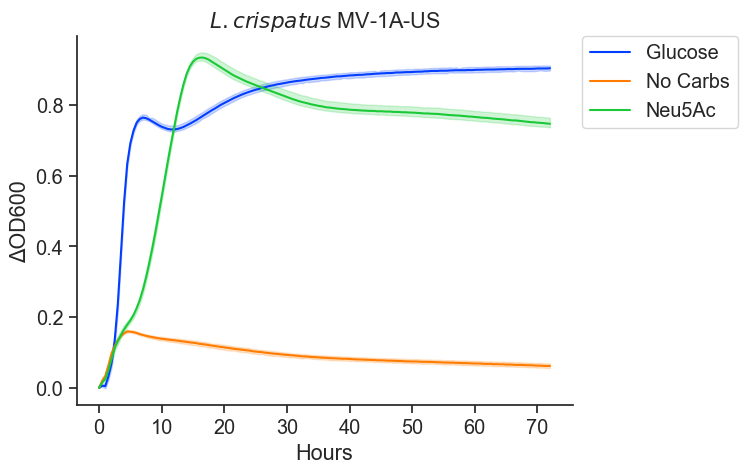

In [38]:
dataToPlot = sliceDFBy(df10724, ['L. crispatus MV-1A-US'], ['Glucose', 'No Carbs', 'Neu5Ac'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ MV-1A-US', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-7-24_Lcrispatus_MV1AUS.png'))

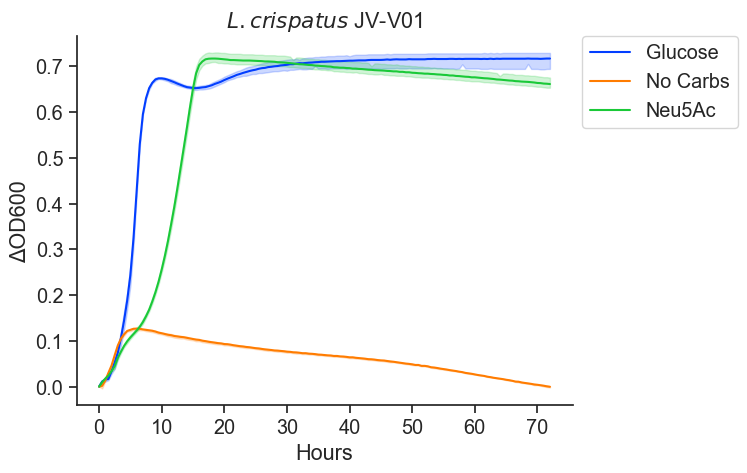

In [39]:
dataToPlot = sliceDFBy(df10724, ['L. crispatus JV-V01'], ['Glucose', 'No Carbs', 'Neu5Ac'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ JV-V01', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-7-24_Lcrispatus_JV-V01.png'))

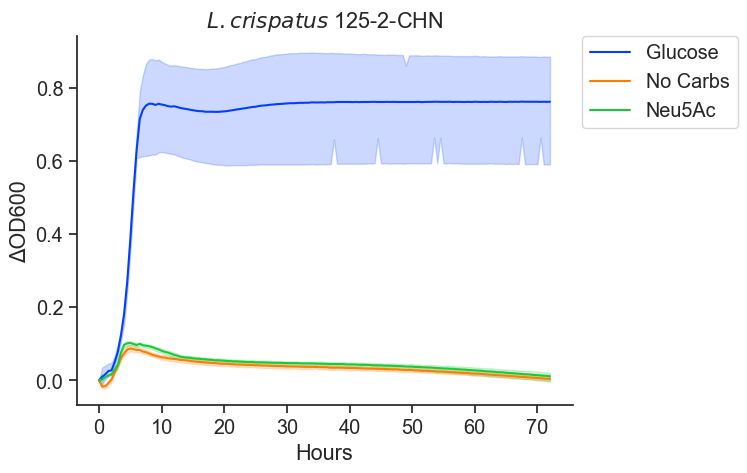

In [40]:
dataToPlot = sliceDFBy(df10724, ['L. crispatus 125-2-CHN'], ['Glucose', 'No Carbs', 'Neu5Ac'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ 125-2-CHN', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-7-24_Lcrispatus_1252CHN.png'))

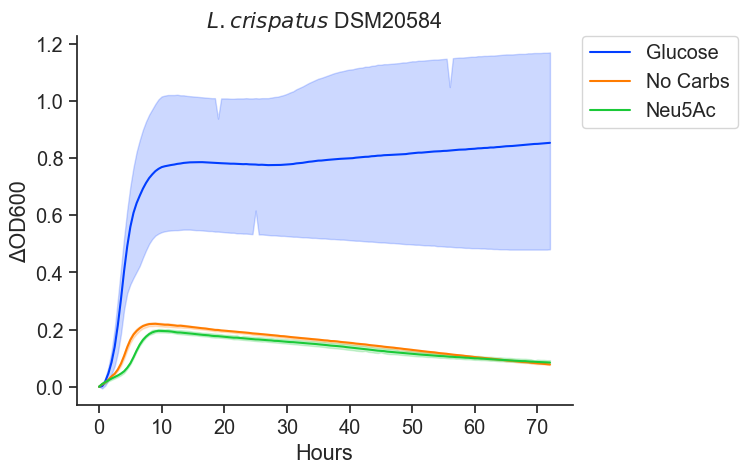

In [41]:
dataToPlot = sliceDFBy(df10724, ['L. crispatus DSM20584'], ['Glucose', 'No Carbs', 'Neu5Ac'])
plot = sns.lineplot(data=dataToPlot, x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. crispatus}$ DSM20584', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-7-24_Lcrispatus_DSM20584.png'))

In [42]:
# Make plots that aggregate the two runs of L. crispatus together into a single graph of growth curves
lcrispAggregateData = pd.read_csv(filepath.joinpath('10-11-24_lcrisp_aggregate.csv'))
aggPalette = []
for i in range(7):
    aggPalette.append(sns.color_palette('bright')[i])
for x in sns.color_palette('pastel', 2):
    aggPalette.append(x)

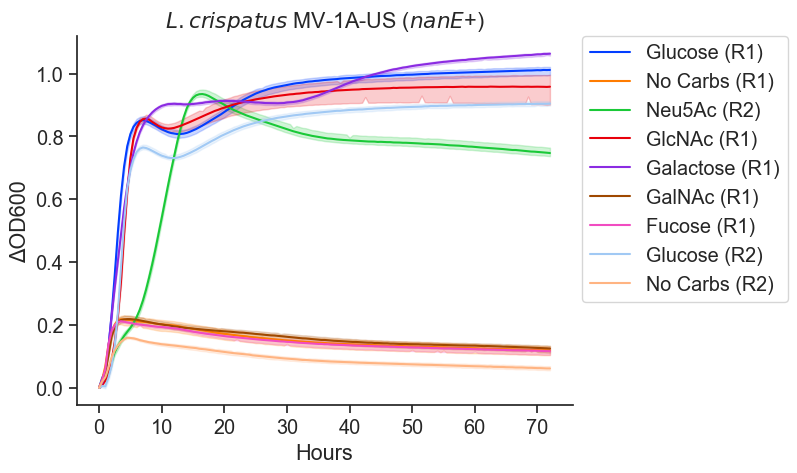

In [44]:
plot = sns.lineplot(data=lcrispAggregateData.drop(lcrispAggregateData[lcrispAggregateData.Strain != 'L. crispatus MV-1A-US'].index), x='Hours', y='Delta OD600', hue='Treatment', palette=aggPalette)
plot.set(title='$\it{L. crispatus}$ MV-1A-US ($\it{nanE}$+)', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-11-24_Lcrispatus_MV-1A-US_aggregate.png'))

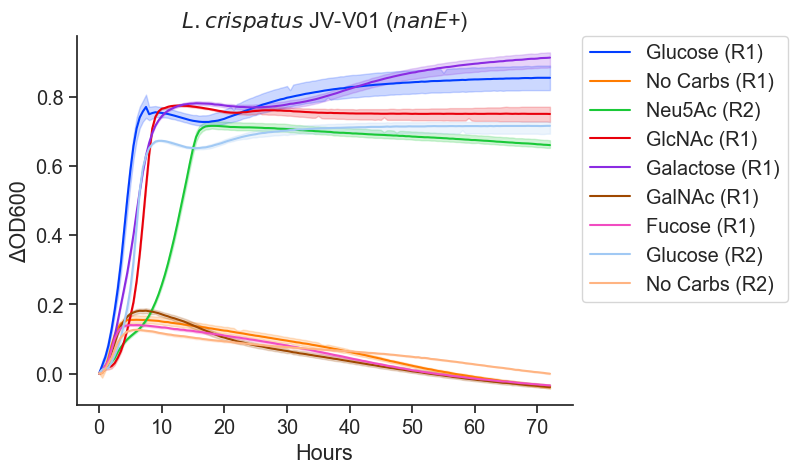

In [45]:
plot = sns.lineplot(data=lcrispAggregateData.drop(lcrispAggregateData[lcrispAggregateData.Strain != 'L. crispatus JV-V01'].index), x='Hours', y='Delta OD600', hue='Treatment', palette=aggPalette)
plot.set(title='$\it{L. crispatus}$ JV-V01 ($\it{nanE}$+)', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-11-24_Lcrispatus_JV-V01_aggregate.png'))

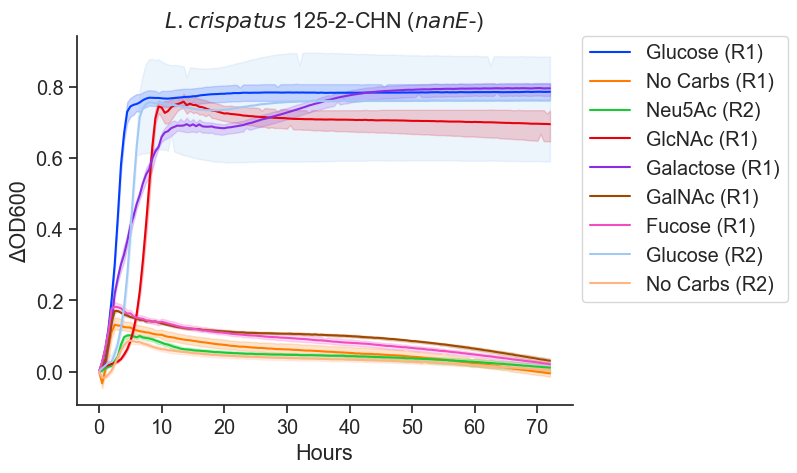

In [46]:
plot = sns.lineplot(data=lcrispAggregateData.drop(lcrispAggregateData[lcrispAggregateData.Strain != 'L. crispatus 125-2-CHN'].index), x='Hours', y='Delta OD600', hue='Treatment', palette=aggPalette)
plot.set(title='$\it{L. crispatus}$ 125-2-CHN ($\it{nanE}$-)', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-11-24_Lcrispatus_1252CHN_aggregate.png'))

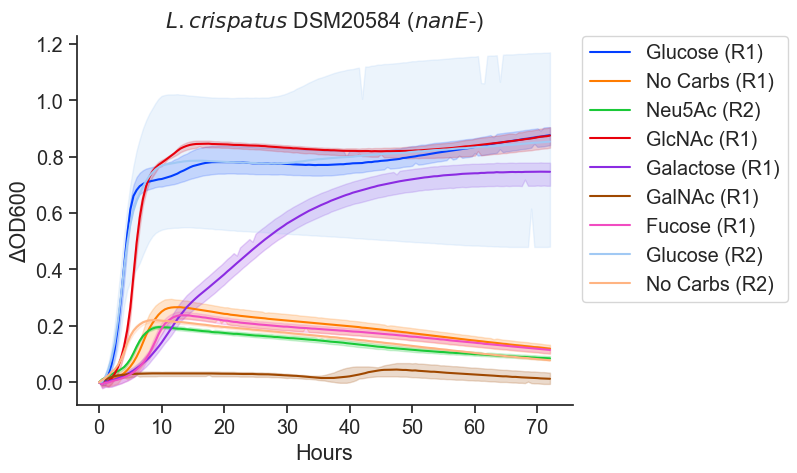

In [47]:
plot = sns.lineplot(data=lcrispAggregateData.drop(lcrispAggregateData[lcrispAggregateData.Strain != 'L. crispatus DSM20584'].index), x='Hours', y='Delta OD600', hue='Treatment', palette=aggPalette)
plot.set(title='$\it{L. crispatus}$ DSM20584 ($\it{nanE}$-)', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-11-24_Lcrispatus_DSM20584_aggregate.png'))

In [48]:
data101024 = pd.read_csv(filepath.joinpath('10-10-24_prevotellas.csv'))

In [49]:
strainLocs = [
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. amnii 21A-a', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df101024 = curveData2df(data101024, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df101024)
#getPercentGrowthDF(df101024, ['H. timonensis DSM22865', 'H. timonensis 5C-B1', 'P. amnii 21A-a', 'P. bivia DNF00650'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('10-10-24_percentgrowth.csv'))
writeEndpointDelta(df101024, filepath.joinpath('10-10-24_endpoints.csv'))

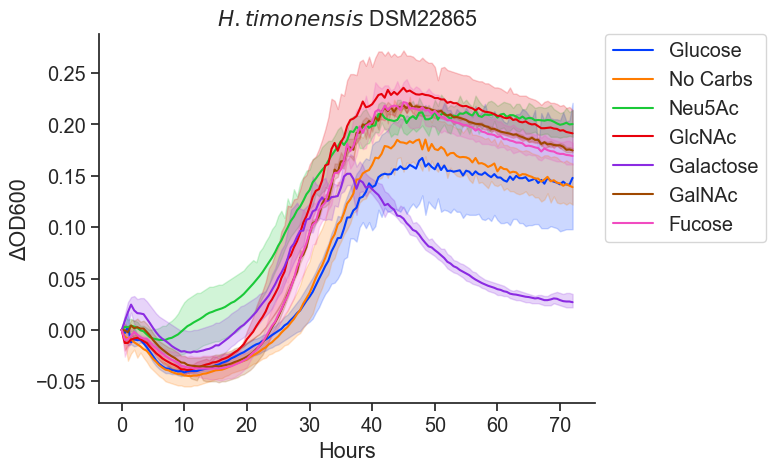

In [50]:
plot = sns.lineplot(data=df101024.drop(df101024[df101024.Strain != 'H. timonensis DSM22865'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ DSM22865', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-10-24_Htimonensis_DSM22865.png'))

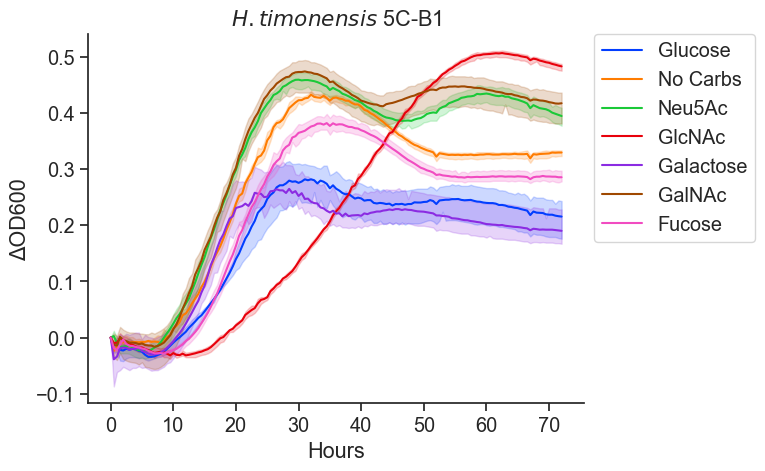

In [51]:
plot = sns.lineplot(data=df101024.drop(df101024[df101024.Strain != 'H. timonensis 5C-B1'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ 5C-B1', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-10-24_Htimonensis_5C-B1.png'))

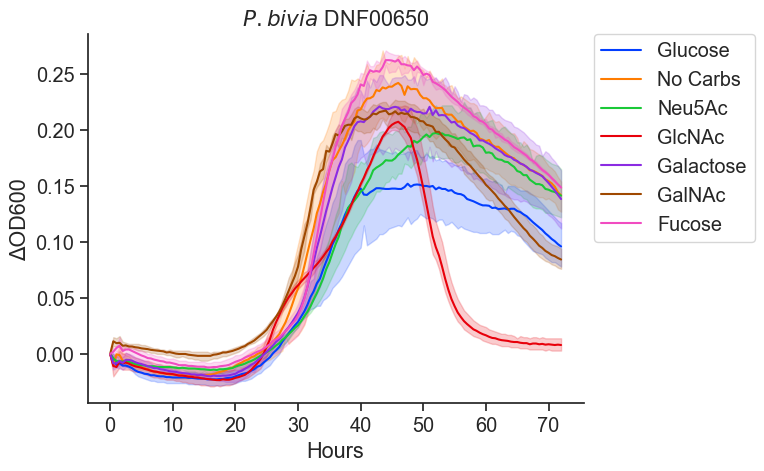

In [53]:
plot = sns.lineplot(data=df101024.drop(df101024[df101024.Strain != 'P. bivia DNF00650'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. bivia}$ DNF00650', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-10-24_Pbivia_DNF00650.png'))

In [54]:
data102324 = pd.read_csv(filepath.joinpath('10-23-24_prevotellas.csv'))

In [55]:
strainLocs = [
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis DSM22865', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. amnii DSM23384', 'P. bivia DNF00650', 'P. bivia DNF00650', 'P. bivia DNF00650'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', '', '', '', '', '']
]
df102324 = curveData2df(data102324, strainLocs, standardTreatmentLocs)
calculateDeltaOD(df102324)
getPercentGrowthDF(df102324, ['H. timonensis DSM22865', 'H. timonensis 5C-B1', 'P. amnii DSM23384', 'P. bivia DNF00650'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('10-23-24_percentgrowth.csv'))

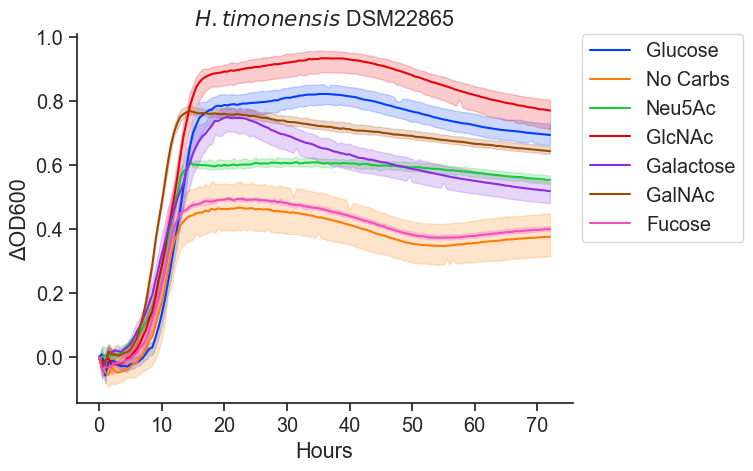

In [56]:
plot = sns.lineplot(data=df102324.drop(df102324[df102324.Strain != 'H. timonensis DSM22865'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ DSM22865', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-23-24_Htimonensis_DSM22865.png'))

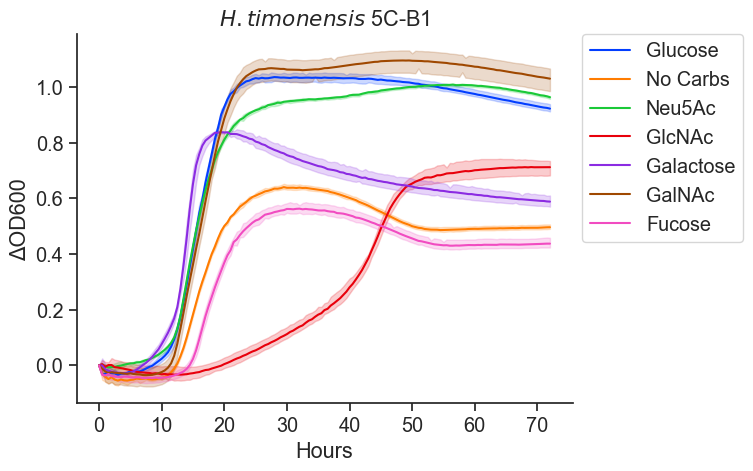

In [57]:
plot = sns.lineplot(data=df102324.drop(df102324[df102324.Strain != 'H. timonensis 5C-B1'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{H. timonensis}$ 5C-B1', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-23-24_Htimonensis_5C-B1.png'))

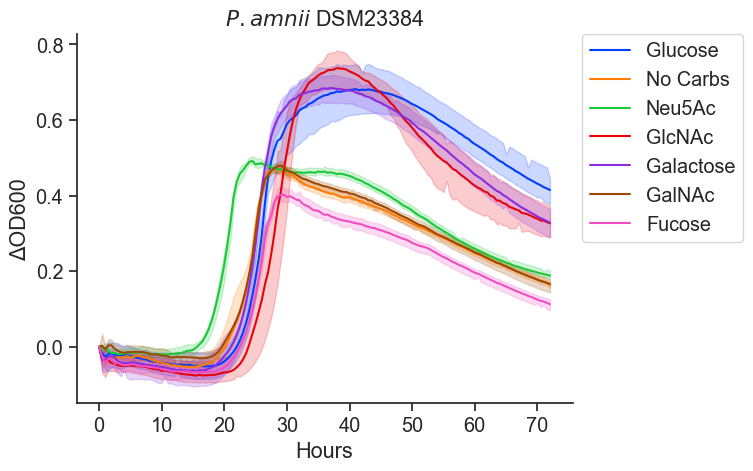

In [58]:
plot = sns.lineplot(data=df102324.drop(df102324[df102324.Strain != 'P. amnii DSM23384'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. amnii}$ DSM23384', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-23-24_Pamnii_DSM23384.png'))

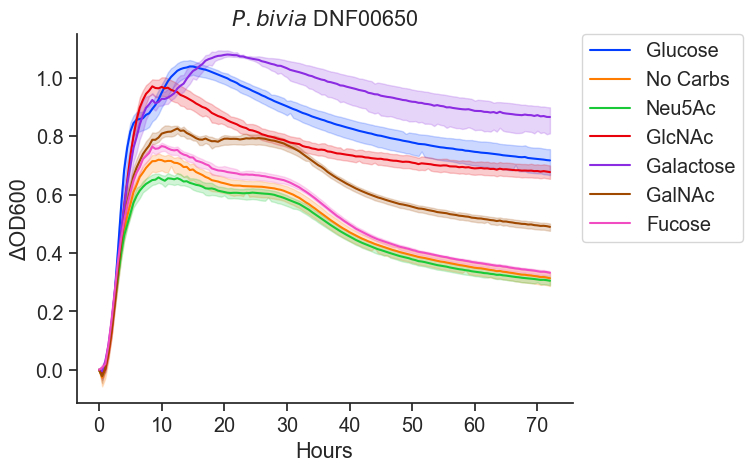

In [59]:
plot = sns.lineplot(data=df102324.drop(df102324[df102324.Strain != 'P. bivia DNF00650'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. bivia}$ DNF00650', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
#saveFig(plot, figurepath.joinpath('10-23-24_Pbivia_DNF650.png'))

In [13]:
data102924 = pd.read_csv(filepath.joinpath('10-29-24_liners_prevotellas.csv'))

In [14]:
strainLocs = [
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['L. iners 143-D', 'L. iners 143-D', 'L. iners 143-D', 'L. iners 2052A-d', 'L. iners 2052A-d', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. amnii 21A-A', 'P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514'],
    ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']
]
treatmentLocs = [
    ['Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose', 'Glucose'],
    ['No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs', 'No Carbs'],
    ['Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac', 'Neu5Ac'],
    ['GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc', 'GlcNAc'],
    ['Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose', 'Galactose'],
    ['GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc', 'GalNAc'],
    ['Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose', 'Fucose'],
    ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose', 'Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose']
]
df102924 = curveData2df(data102924, strainLocs, treatmentLocs)
calculateDeltaOD(df102924)
getPercentGrowthDF(df102924, ['L. iners 143-D', 'L. iners 2052A-d', 'P. amnii 21A-A', 'P. bivia DSM20514'], ['Glucose', 'No Carbs', 'Neu5Ac', 'GlcNAc', 'Galactose', 'GalNAc', 'Fucose']).to_csv(filepath.joinpath('10-29-24_percentgrowth.csv'))

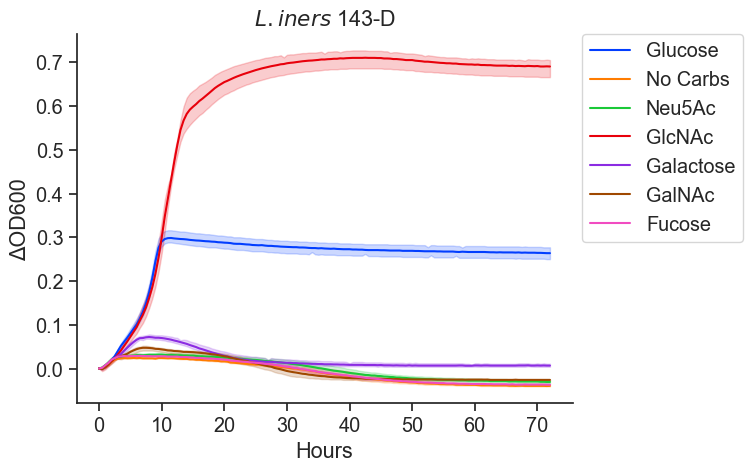

In [15]:
plot = sns.lineplot(data=df102924.drop(df102924[df102924.Strain != 'L. iners 143-D'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. iners}$ 143-D', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
saveFig(plot, figurepath.joinpath('10-29-24_Liners_143D.png'))

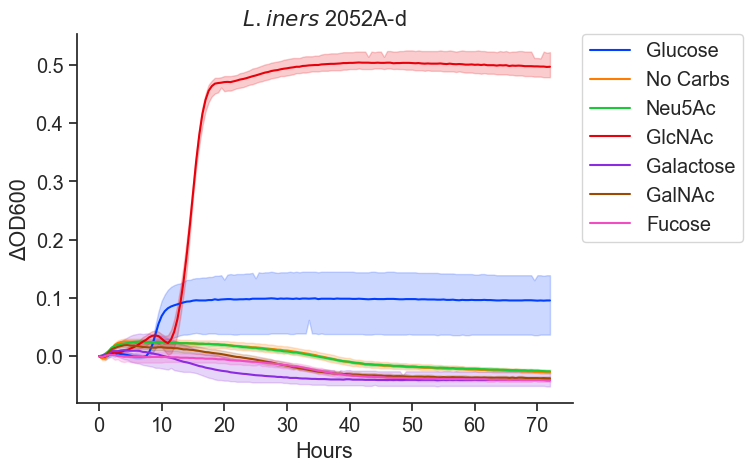

In [16]:
plot = sns.lineplot(data=df102924.drop(df102924[df102924.Strain != 'L. iners 2052A-d'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{L. iners}$ 2052A-d', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
saveFig(plot, figurepath.joinpath('10-29-24_Liners_2052ad.png'))

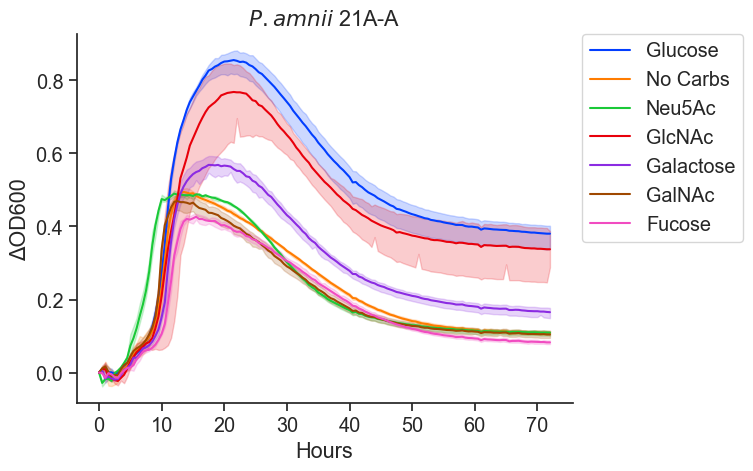

In [17]:
plot = sns.lineplot(data=df102924.drop(df102924[df102924.Strain != 'P. amnii 21A-A'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. amnii}$ 21A-A', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
saveFig(plot, figurepath.joinpath('10-29-24_Pamnii_21aa.png'))

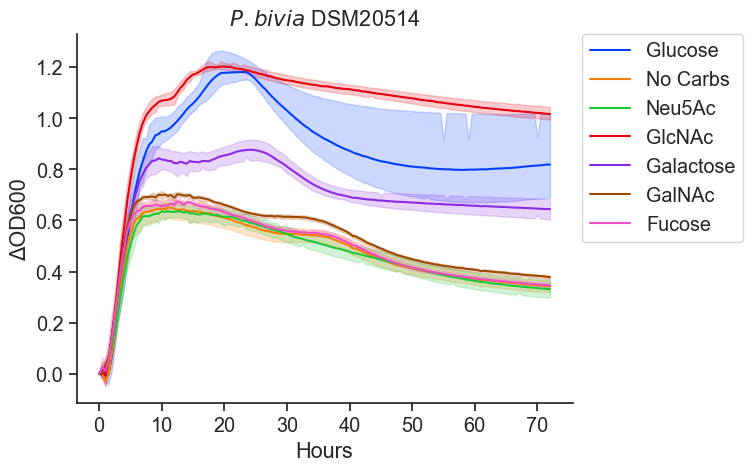

In [18]:
plot = sns.lineplot(data=df102924.drop(df102924[df102924.Strain != 'P. bivia DSM20514'].index), x='Hours', y='Delta OD600', hue='Treatment')
plot.set(title='$\it{P. bivia}$ DSM20514', ylabel='ΔOD600')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.despine()
saveFig(plot, figurepath.joinpath('10-29-24_Pbivia_dsm20514.png'))

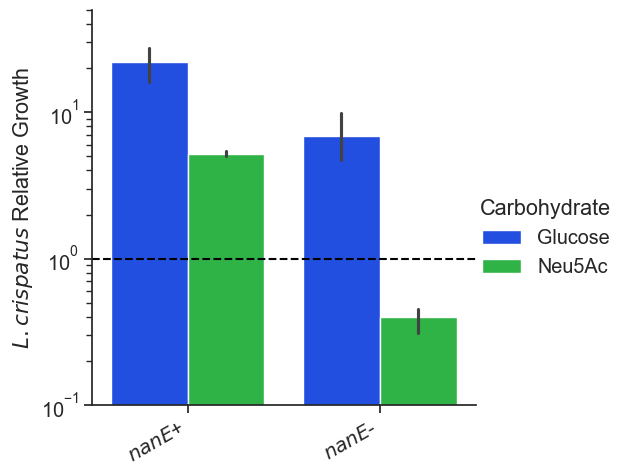

In [25]:
dataToPlot = pd.read_csv(filepath.joinpath('12-5-24_neu5ac_competition_ph6.csv'))
plot = sns.catplot(data=dataToPlot, x='Genotype', y='L. crispatus Relative Growth', hue='Carbohydrate', kind='bar', palette=[sns.color_palette('bright')[0], sns.color_palette('bright')[2]])
plot.set(yscale='log', ylim=(1e-1, 5e1), xlabel='', ylabel='$\it{L. crispatus}$ Relative Growth')
plot.set_xticklabels(['$\it{nanE}$+', '$\it{nanE}$-'], rotation=30, ha='right')
plt.axhline(y=1, color='black', ls='--')
plot.savefig(figurepath.joinpath('12-5-24_competition_genotype.png'), dpi=300, bbox_inches='tight')

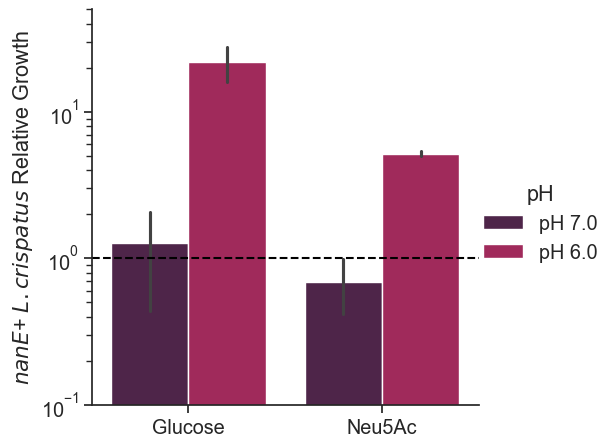

In [29]:
dataToPlot = pd.read_csv(filepath.joinpath('12-5-24_neu5ac_competition_neu5ac.csv'))
plot = sns.catplot(data=dataToPlot, x='Carbohydrate', y='L. crispatus Relative Growth', hue='pH', kind='bar', palette=[sns.color_palette('rocket', 8)[1], sns.color_palette('rocket', 8)[3]])# palette=[sns.color_palette('bright')[0], sns.color_palette('bright')[2]])
plot.set(yscale='log', ylim=(1e-1, 5e1), xlabel='', ylabel='$\it{nanE}$+ $\it{L. crispatus}$ Relative Growth')
plt.axhline(y=1, color='black', ls='--')
plot.savefig(figurepath.joinpath('12-5-24_competition_pH.png'), dpi=300, bbox_inches='tight')

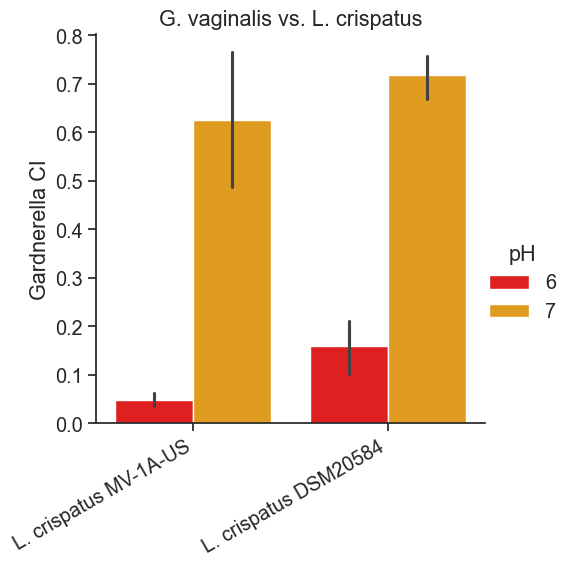

In [51]:
dataToPlot = pd.read_csv(filepath.joinpath('12-5-24_neu5ac_competition_pHeffect.csv'))
plot = sns.catplot(data=dataToPlot, x='Strain', y='Gardnerella CI', hue='pH', kind='bar', palette=['red', 'orange'])
plot.set(title='G. vaginalis vs. L. crispatus', xlabel='')
plot.set_xticklabels(rotation=30, ha='right')